In [2]:
import random

import numpy as np
import scipy.spatial
import torch
from sklearn import metrics
from sklearn.neighbors import LocalOutlierFactor
import csv
from scipy.spatial import distance, distance_matrix
import os
import io
from PIL import Image
import base64
import math
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0,'/home/yashar/git/python/AD-with-GANs')
from src.ml.models.matrix_a_linear import MatrixALinear
from src.ml.models.generator import Generator

ModuleNotFoundError: No module named 'scipy'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_folder = '/Users/yasharh@miltenyibiotec.de/git/AD-with-GANs'
base_folder = '/home/yashar/git/python/AD-with-GANs'

In [7]:
def mahalanobis_distance(u, mean, vi):
    return distance.mahalanobis(u, mean, vi)

In [8]:
def plot_to_base64(plot):
    io_bytes = io.BytesIO()
    plot.savefig(io_bytes, format='jpg')
    io_bytes.seek(0)
    return base64.b64encode(io_bytes.read()).decode()

def get_roc_curve_as_base64(label, values):
    plt.clf()
    values = [0 if math.isnan(x) else x for x in values]
    fpr, tpr, thresholds = metrics.roc_curve(label, values)
    auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                                      estimator_name='LOF')
    display.plot()
    return plot_to_base64(plt), auc

In [9]:
def load_latent_space_data_points(base_url):
    path = os.path.join(base_url, "latent_space_mappings.csv")
    data_points = []
    data_labels = []
    with open(path, 'r') as csvfile:
        datareader = csv.reader(csvfile)
        next(datareader)
        for row in datareader:
            latent_space_point_path = os.path.join(base_url, row[0])
            latent_space_point_pt = torch.squeeze(
                torch.load(latent_space_point_path, map_location=torch.device(device)).detach())
            latent_space_point = latent_space_point_pt.numpy()
            data_points.append(latent_space_point)
            data_labels.append(row[2])

    return data_points, data_labels

In [10]:
def extract_weights_from_model_and_apply_pca(matrix_a_linear, pca_component_count, pca_skipped_components_count,
                                             apply_standard_scaler):
    if pca_component_count == 0:
        return matrix_a_linear.linear.weight.data.numpy().T

    matrix_a_np = matrix_a_linear.linear.weight.data.numpy()
    if apply_standard_scaler:
        matrix_a_np = StandardScaler().fit_transform(matrix_a_np)
    pca = PCA(n_components=pca_component_count + pca_skipped_components_count)
    principal_components = pca.fit_transform(matrix_a_np)
    return principal_components[:, pca_skipped_components_count:].T

In [11]:
def get_auc_value_plain_mahalanobis_distance(matrix_a_linear, anomalous_directions, pca_component_count,
                                             pca_skipped_components_count, pca_apply_standard_scaler=False):
    a = extract_weights_from_model_and_apply_pca(matrix_a_linear,
                                                 pca_component_count,
                                                 pca_skipped_components_count,
                                                 pca_apply_standard_scaler)

    labeled_directions = []

    # Remove directions that were not labeled
    for idx, direction in enumerate(a):
        if idx in anomalous_directions:
            labeled_directions.append(direction)

    # Weigh down directions that were not labeled
    # for idx, direction in enumerate(a):
    #     if idx not in anomalous_directions:
    #         labeled_directions.append(direction*0.1)
    #     else:
    #         labeled_directions.append(direction*0.5)

    # Replace normal directions with zero-vectors
    # for idx, direction in enumerate(a):
    #     if idx not in anomalous_directions:
    #         labeled_directions.append(np.zeros_like(direction))
    #     else:
    #         labeled_directions.append(direction)

    labeled_directions = np.array(labeled_directions)
    test_data_points, test_data_label = load_latent_space_data_points(os.path.join(base_folder, 'data/LatentSpaceMNIST'))

    # Scale Data
    # labeled_directions = StandardScaler().fit_transform(labeled_directions)
    # test_data_points = StandardScaler().fit_transform(test_data_points)

    # Apply PCA on data_points
    # if pca_component_count > 0:
    #     pca = PCA(n_components=pca_component_count + pca_skipped_components_count)
    #     principal_components = pca.fit_transform(test_data_points)
    #     test_data_points = principal_components[:, pca_skipped_components_count:]
    #     print(pca.explained_variance_ratio_)

    # Use labeled directions as reference
    # cov = np.cov(labeled_directions.T)
    # vi = np.linalg.inv(cov)
    # mean_vector = np.mean(labeled_directions, axis=0)

    # Use data distribution as reference
    data = np.array(test_data_points)
    v = np.cov(data.T)
    vi = np.linalg.inv(v)
    # mean_vector = np.mean(data, axis=0)
    mean_vector = np.mean(labeled_directions, axis=0)

    distance_list = []
    label_list = []
    for idx, point in enumerate(test_data_points):
        dist = mahalanobis_distance(u=point, mean=mean_vector, vi=vi)
        if not np.isnan(dist):
            distance_list.append(dist)
            label_list.append(1 if test_data_label[idx] == "True" else -1)
            
    fpr, tpr, thresholds = metrics.roc_curve(label_list, distance_list)
    return metrics.auc(fpr, tpr)

In [12]:
def get_auc_value_via_pairwise_distances(matrix_a_linear, anomalous_directions, pca_component_count,
                                         pca_skipped_components_count, pca_apply_standard_scaler=False):
    a = extract_weights_from_model_and_apply_pca(matrix_a_linear,
                                                 pca_component_count,
                                                 pca_skipped_components_count,
                                                 pca_apply_standard_scaler)

    labeled_directions = []

    # Remove directions that were not labeled
    for idx, direction in enumerate(a):
        if idx in anomalous_directions:
            labeled_directions.append(direction)


    labeled_directions = np.array(labeled_directions)
    test_data_points, test_data_label = load_latent_space_data_points(os.path.join(base_folder, 'data/LatentSpaceMNIST'))

    # Scale Data
    labeled_directions = StandardScaler().fit_transform(labeled_directions)
    test_data_points = StandardScaler().fit_transform(test_data_points)

    # Apply PCA on data_points
    # if pca_component_count > 0:
    #     pca = PCA(n_components=pca_component_count + pca_skipped_components_count)
    #     principal_components = pca.fit_transform(test_data_points)
    #     test_data_points = principal_components[:, pca_skipped_components_count:]
    #     print(pca.explained_variance_ratio_)

    mean_vector = np.mean(labeled_directions, axis=0)

    distance_list = []
    label_list = []
    for idx, point in enumerate(test_data_points):
        dist = 0
        for d in labeled_directions:
            dist += np.linalg.norm(point-d)
        
        distance_list.append(dist)                
        label_list.append(True if test_data_label[idx] == "True" else False)

    fpr, tpr, thresholds = metrics.roc_curve(label_list, distance_list)
    return metrics.auc(fpr, tpr)

In [13]:
def display_base64_png(base64_string):
    imgdata = base64.b64decode(str(base64_string))
    img = Image.open(io.BytesIO(imgdata))
    img.show()

In [14]:
generator_path = os.path.join(base_folder, 'saved_models/generator.pkl')
matrix_a_path = os.path.join(base_folder, 'saved_models/matrix_a.pkl')
z_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g: Generator = Generator(size_z=z_dim, num_feature_maps=64, num_color_channels=1)
g.load_state_dict(torch.load(generator_path, map_location=torch.device(device)))
matrix_a_linear: MatrixALinear = MatrixALinear(input_dim=100, output_dim=100, bias=False)
matrix_a_linear.load_state_dict(torch.load(matrix_a_path, map_location=torch.device(device)))

<All keys matched successfully>

In [15]:
auc_plain_mahalanobis = get_auc_value_plain_mahalanobis_distance(matrix_a_linear=matrix_a_linear,
                                                                 # anomalous_directions=[9, 16, 17, 18, 20, 22, 23, 27,
                                                                 #                       28, 33, 34, 35, 36, 47, 50, 51,
                                                                 #                       57, 59, 60, 70, 75, 76, 80, 84,
                                                                 #                       85, 88, 98, 99],
                                                                 # anomalous_directions=range(0, 100),
                                                                 anomalous_directions=[0, 1, 7, 8, 18, 19, 20, 21, 23, 26, 28],
                                                                 # anomalous_directions=[2],
                                                                 # anomalous_directions=range(0, 100),
                                                                 pca_component_count=30,
                                                                 pca_skipped_components_count=1,
                                                                 pca_apply_standard_scaler=False)
print(auc_plain_mahalanobis)

0.6512598935522518


In [16]:
auc_distance_matrix = get_auc_value_via_pairwise_distances(matrix_a_linear=matrix_a_linear,
                                                           # anomalous_directions=[9, 16, 17, 18, 20, 22, 23, 27,
                                                           #                       28, 33, 34, 35, 36, 47, 50, 51,
                                                           #                       57, 59, 60, 70, 75, 76, 80, 84,
                                                           #                       85, 88, 98, 99],
                                                           # anomalous_directions=range(0, 100),
                                                           anomalous_directions=[0, 1, 7, 8, 18, 19, 20, 21, 23, 26],
                                                           # anomalous_directions=[2],
                                                           pca_component_count=30,
                                                           pca_skipped_components_count=3,
                                                           pca_apply_standard_scaler=False)
print(auc_distance_matrix)

0.6519826384115325


Local Outlier Factor

In [17]:
class WeightedLocalOutlierFactor:
    def __init__(self,
                 direction_matrix, anomalous_directions, n_neighbours, pca_component_count=0,
                 skipped_components_count=0, ignore_labels=False):
        self.data = []
        self.direction_matrix = direction_matrix #.linear.weight.data.numpy()
        self.pca = PCA(n_components=pca_component_count + skipped_components_count)

        self.labeled_directions = []
        # for idx, val in enumerate(anomalous_directions):
        #     self.labeled_directions.append(self.direction_matrix.T[val])
        # self.labeled_directions = np.array(self.labeled_directions)

        for idx, direction in enumerate(direction_matrix):
            if idx in anomalous_directions:
                self.labeled_directions.append(direction)
        self.labeled_directions = np.array(self.labeled_directions)

        # mean_array = np.matrix(labeled_directions).mean(0).A1
        #
        # for idx, col in enumerate(self.direction_matrix):
        #     if idx not in labeled_dims:
        #         self.direction_matrix[idx] = mean_array

        # for idx, col in enumerate(self.direction_matrix):
        #     if idx not in labeled_dims:
        #         self.direction_matrix[idx] = col * 0.01
        #
        # cov = np.cov(self.direction_matrix)
        # self.vi = np.linalg.inv(cov)

        # cov = np.cov(self.labeled_directions.T)
        # self.vi = np.linalg.inv(cov)
        cov = np.cov(self.labeled_directions.T)
        self.vi = cov

        # for idx, col in enumerate(self.direction_matrix):
        #     if idx not in labeled_dims:
        #         self.direction_matrix[idx] = col*0.01

        self.lof = LocalOutlierFactor(
            n_neighbors=n_neighbours,
            metric=self.__get_mahalanobis_distance if not ignore_labels else "minkowski",
        )

        self.pca_component_count = pca_component_count
        self.skipped_components_count = skipped_components_count

    def fit(self):
        data_as_array = np.array(self.data)
        self.lof.fit_predict(data_as_array)

    def load_latent_space_datapoints(self, data=[], root_dir=''):
        if len(data) > 0:
            self.data = np.array(data)
        else:
            directory = os.fsencode(root_dir)
            for file in os.listdir(directory):
                filename = os.fsdecode(file)
                if filename.endswith(".pt"):
                    path = os.path.join(root_dir, filename)
                    self.data.append(torch.load(path, map_location=torch.device('cpu')).detach().numpy().reshape(100))
            self.data = np.array(self.data)
        
        
        # if self.pca_component_count > 0:
        #     assert self.pca_component_count + self.skipped_components_count < self.data.shape[1], \
        #         "pca_component_count+skipped_components_count must be smaller then total number of columns"
        #
        #     self.pca_component_count = self.pca_component_count + self.skipped_components_count
        #     data = self.data
        #     data = StandardScaler().fit_transform(data)
        #     principal_components = self.pca.fit_transform(data)
        #     self.data = principal_components[:, self.skipped_components_count:]

    def get_negative_outlier_factor(self):
        return self.lof.negative_outlier_factor_

    # def __get_mahalanobis_distance(self, u, v):
    #     return distance.mahalanobis(u, v, self.direction_matrix.T)

    def __get_mahalanobis_distance(self, u, v):
        return distance.mahalanobis(u, v, self.vi)

In [18]:
def get_roc_auc_for_given_dims(direction_matrix, anomalous_directions, latent_space_data_points,
                               latent_space_data_labels,
                               pca_component_count,
                               pca_skipped_components_count, n_neighbours, pca_apply_standard_scaler=True,
                               weight_factor=10, one_hot_weighing=True, ignore_labels=False):
    a = extract_weights_from_model_and_apply_pca(direction_matrix, pca_component_count, pca_skipped_components_count,
                              pca_apply_standard_scaler)
    weighted_lof = WeightedLocalOutlierFactor(direction_matrix=a,
                                              anomalous_directions=anomalous_directions,
                                              n_neighbours=n_neighbours,
                                              pca_component_count=pca_component_count,
                                              skipped_components_count=pca_skipped_components_count,
                                              ignore_labels=ignore_labels)

    weighted_lof.load_latent_space_datapoints(data=latent_space_data_points)
    weighted_lof.fit()

    y = np.array([1 if d == "False" else -1 for d in latent_space_data_labels])
    return get_roc_curve_as_base64(y, weighted_lof.get_negative_outlier_factor())

0.7259972111475539


<Figure size 640x480 with 0 Axes>

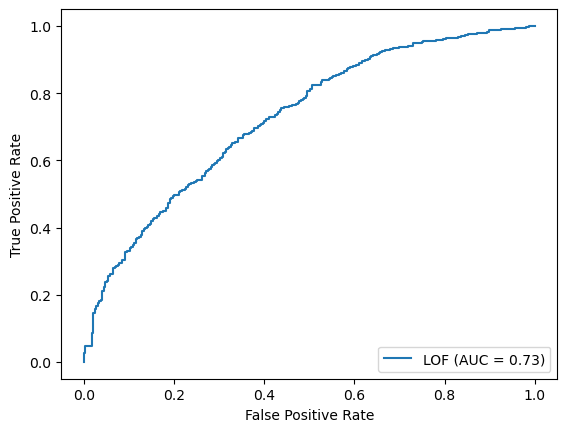

In [19]:
latent_space_data_points, latent_space_data_labels = load_latent_space_data_points(os.path.join(base_folder, 'data/LatentSpaceMNIST'))
curve, auc_lof = get_roc_auc_for_given_dims(direction_matrix=matrix_a_linear,
                                        # anomalous_directions=[0, 1, 2, 3, 7, 8, 18, 19, 20, 21, 23, 26, 27, 28, 30],
                                        # anomalous_directions=[2, 3, 4, 5], 
                                        anomalous_directions=range(0, 30),
                                        latent_space_data_points=latent_space_data_points,
                                        latent_space_data_labels=latent_space_data_labels,
                                        pca_component_count=20,
                                        pca_skipped_components_count=3,
                                        n_neighbours=10,
                                        pca_apply_standard_scaler=True,
                                        ignore_labels=False)
print(auc_lof)